<a href="https://colab.research.google.com/github/Kyezil/cs231n-solutions/blob/master/assignment2/FullyConnectedNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

### Download and load the required files

In [2]:
%cd
!rm -rf cs231n-solutions
!git clone https://github.com/Kyezil/cs231n-solutions.git
%cd cs231n-solutions/
!git checkout A2
%cd assignment2
!ls

/root
Cloning into 'cs231n-solutions'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 117 (delta 31), reused 69 (delta 21), pack-reused 23
Receiving objects: 100% (117/117), 3.06 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/root/cs231n-solutions
Note: checking out 'A2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 322a269 add cs231n for assignment2
/root/cs231n-solutions/assignment2
cs231n


In [3]:
!cd cs231n/datasets/ && bash get_datasets.sh

--2019-02-21 23:06:16--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.82MB/s    in 25s     

2019-02-21 23:06:41 (6.51 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [4]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [5]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [0]:
# cs231n/layers.py
from builtins import range
import numpy as np

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    out = x.reshape(x.shape[0], -1) @ w + b
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

In [7]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [0]:
# cs231n/layers.py
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    dx = (dout @ w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T @ dout
    db = dout.sum(axis=0)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


In [9]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [0]:
# cs231n/layers.py
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    out = np.maximum(0, x)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


In [11]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [0]:
# cs231n/layers.py
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    dx = dout
    dx[x < 0] = 0
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [13]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Sigmoid, ReLU
- Sigmoid saturates easily for high absolute values and returns 0 gradient
- ReLU has 0 gradient for negative x


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [14]:
# checkout previous code
!git checkout master
!git pull
!git checkout A2Q1S1

Previous HEAD position was 322a269 add cs231n for assignment2
Switched to branch 'master'
Your branch is up to date with 'origin/master'.
Already up to date.
Note: checking out 'A2Q1S1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 11a0f12 finish afine and relu forward&backward


In [15]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [16]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [0]:
# cs231n/classifiers/fc_net.py
from builtins import range
from builtins import object
import numpy as np

from cs231n.layers import *
from cs231n.layer_utils import *


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        self.params['W1'] = np.random.normal(0, weight_scale, (input_dim, hidden_dim))
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = np.random.normal(0, weight_scale, (hidden_dim, num_classes))
        self.params['b2'] = np.zeros(num_classes)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        aff, aff_cache = affine_forward(X, self.params['W1'], self.params['b1'])
        relu, relu_cache = relu_forward(aff)
        scores, scores_cache = affine_forward(relu, self.params['W2'], self.params['b2'])       
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dL_scores = softmax_loss(scores, y)
        
        dL_relu, grads['W2'], grads['b2'] = affine_backward(dL_scores, scores_cache)
        dL_aff = relu_backward(dL_relu, relu_cache)
        dL_X, grads['W1'], grads['b1'] = affine_backward(dL_aff, aff_cache)
       
        # regularization terms
        loss += self.reg * 0.5 * (np.sum(self.params['W1'] ** 2) +
                                  np.sum(self.params['W2'] ** 2))
        
        grads['W1'] += self.reg * self.params['W1']
        grads['W2'] += self.reg * self.params['W2']
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [18]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [19]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data,
               update_rule='sgd',
               optim_config={
                   'learning_rate': 1e-3,
               },
               lr_decay = 0.95,
               num_epochs=10, batch_size = 100,
               print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

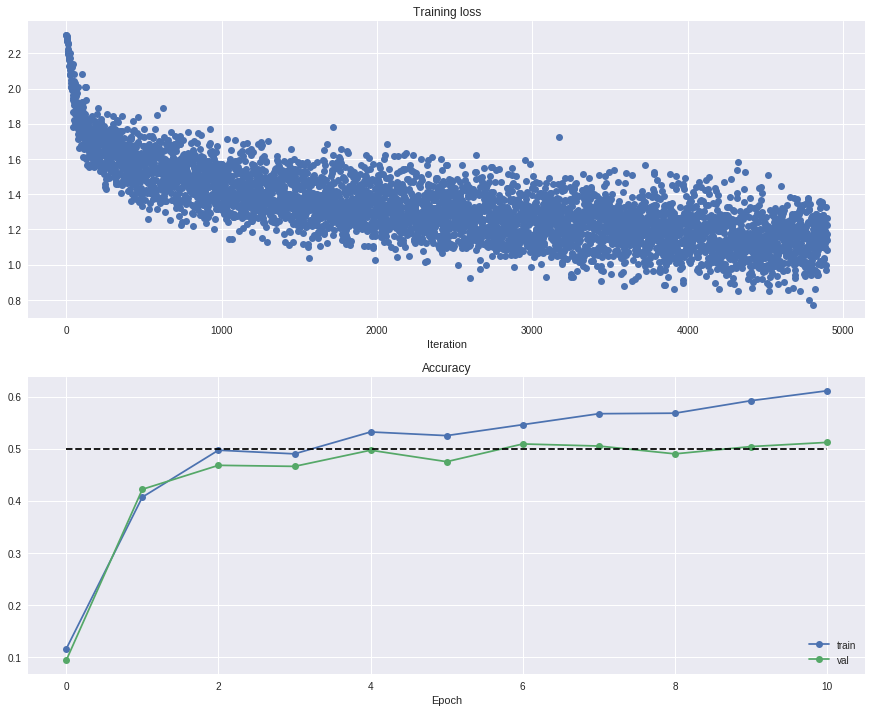

In [20]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

In [0]:
# cs231n/classifiers/fc_net.py
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=1, normalization=None, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        dims = [input_dim] + hidden_dims + [num_classes]
        for i in range(self.num_layers):
          self.params[f"W{i+1}"] = np.random.normal(0, weight_scale,
                                                    (dims[i], dims[i+1]))
          self.params[f"b{i+1}"] = np.zeros(dims[i+1])
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization=='batchnorm':
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
        if self.normalization=='layernorm':
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.normalization=='batchnorm':
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        caches = [None] * self.num_layers
        scores = X # store last activation
        
        for i in range(1, self.num_layers+1):
          # run affine
          scores, aff_cache = affine_forward(scores, self.params[f"W{i}"],
                                                     self.params[f"b{i}"])
          if i < self.num_layers: # not last layer
            # batch
            # relu
            scores, relu_cache = relu_forward(scores)
            # dropout
            caches[i-1] = (aff_cache, relu_cache)
          else:
            caches[i-1] = (aff_cache, None)
          
            
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dout = softmax_loss(scores, y)
        for i in range(self.num_layers, 0, -1): # opposite direction
          aff_cache, relu_cache = caches[i-1]

          if i < self.num_layers: # not the last layer
            # dropout
            # relu
            dout = relu_backward(dout, relu_cache)
            # batch
         
          # affine
          dout, dw, db = affine_backward(dout, aff_cache)
          grads[f"W{i}"] = dw + self.reg * self.params[f"W{i}"]
          grads[f"b{i}"] = db
          # add regularization to loss
          loss += 0.5 * self.reg * np.sum(self.params[f"W{i}"]**2)      
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [22]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

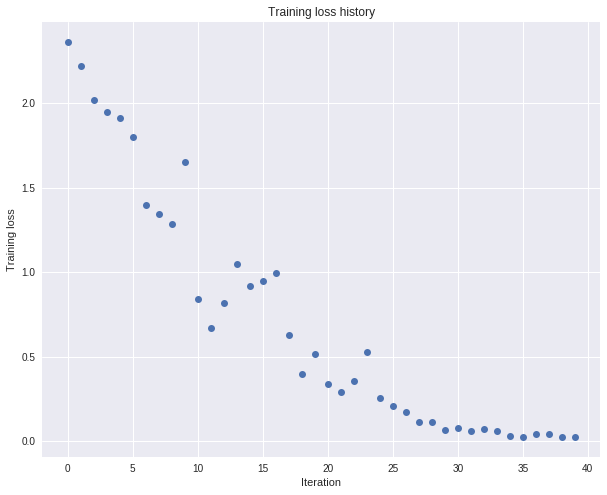

In [23]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 5.557032
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.085000
(Epoch 2 / 20) train acc: 0.260000; val_acc: 0.116000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.125000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.139000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.133000
(Iteration 11 / 40) loss: 0.919214
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.134000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.150000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.146000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.140000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.147000
(Iteration 21 / 40) loss: 0.304914
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.149000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.143000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.155000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.138000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.141000
(Iteration 31 / 40) loss: 

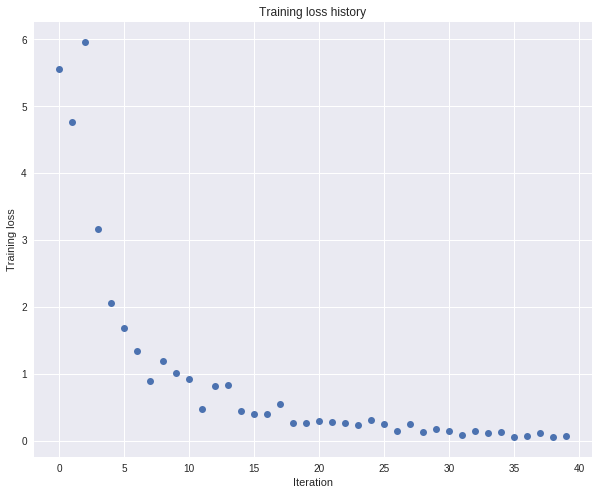

In [24]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2
weight_scale = 5e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
Oh yeah, the five layer net was much more sensitive. A factor of 5 made a great difference in the behaviour while the 3-layer one was smoother in its response to weight scale changes.

It may be the case that by adding layers we develop a more complex model and the optimization landscape is less smooth.
Also the weights have greater influence as we increase the number of layers, the input data may complete disappear.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [25]:
!git checkout master
!git pull
!git checkout A2Q1S2

Previous HEAD position was 11a0f12 finish afine and relu forward&backward
Switched to branch 'master'
Your branch is up to date with 'origin/master'.
Already up to date.
Note: checking out 'A2Q1S2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 596b6ba implement sgd momentum


In [26]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291087
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.023753
(Iteration 71 / 200) loss: 2.026621
(Epoch 2 / 5) train acc: 0.352000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.807164
(Iteration 91 / 200) loss: 1.915726
(Iteration 101 / 200) loss: 1.921844
(Iteration 111 / 200) loss: 1.708426
(Epoch 3 / 5) train acc: 0.399000; val_acc: 0.318000
(Iteration 121 / 200) loss: 1.699806
(Iteration 131 / 200) loss: 1.771857
(Iteration 141 / 200) loss: 1.790065
(Iteration 151 / 200) loss: 1.820861
(Epoch 4 / 5) train acc: 0.430000; val_acc: 0.324000
(Iteration 161 / 200) loss: 1.627657
(Iteration 171 / 200) loss: 1.899449
(Iteration 181 / 200) loss: 1.551447
(Iteration 191 / 200) los

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


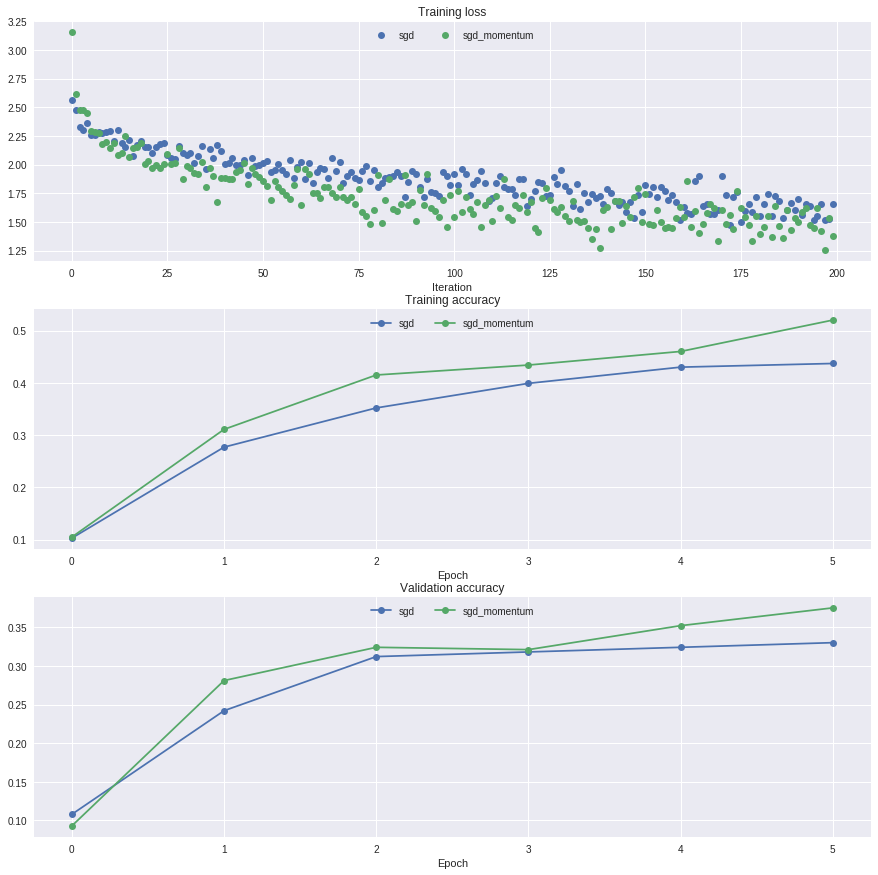

In [27]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [0]:
def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('decay_rate', 0.99)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('cache', np.zeros_like(w))

    next_w = None
    ###########################################################################
    # TODO: Implement the RMSprop update formula, storing the next value of w #
    # in the next_w variable. Don't forget to update cache value stored in    #
    # config['cache'].                                                        #
    ###########################################################################
    config['cache'] = config['decay_rate']*config['cache'] + \
                      (1-config['decay_rate'])*(dw**2)
    next_w = w - config['learning_rate']*dw / (np.sqrt(config['cache']) + config['epsilon'])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return next_w, config

In [29]:
# Test RMSProp implementation
#from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [0]:
def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    next_w = None
    ###########################################################################
    # TODO: Implement the Adam update formula, storing the next value of w in #
    # the next_w variable. Don't forget to update the m, v, and t variables   #
    # stored in config.                                                       #
    #                                                                         #
    # NOTE: In order to match the reference output, please modify t _before_  #
    # using it in any calculations.                                           #
    ###########################################################################
    t, m, v = config['t'], config['m'], config['v']
    
    m = config['beta1']*m + (1 - config['beta1']) * dw
    v = config['beta2']*v + (1 - config['beta2']) * (dw**2)
    t += 1
    
    mb = m/(1 - config['beta1']**t)
    vb = v/(1 - config['beta2']**t)
    
    next_w = w - config['learning_rate']*mb / (np.sqrt(vb) + config['epsilon'])
    
    config['t'], config['m'], config['v'] = t, m, v
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return next_w, config

In [31]:
# Test Adam implementation
#from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [32]:
!git checkout master
!git pull
!git checkout A2Q1S3

Previous HEAD position was 596b6ba implement sgd momentum
Switched to branch 'master'
Your branch is up to date with 'origin/master'.
Already up to date.
Note: checking out 'A2Q1S3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 76740b9 implement rmsprop and adam


running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505514
(Epoch 2 / 5) train acc: 0.416000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594391
(Iteration 91 / 200) loss: 1.483393
(Iteration 101 / 200) loss: 1.391985
(Iteration 111 / 200) loss: 1.410419
(Epoch 3 / 5) train acc: 0.496000; val_acc: 0.374000
(Iteration 121 / 200) loss: 1.190327
(Iteration 131 / 200) loss: 1.446230
(Iteration 141 / 200) loss: 1.358681
(Iteration 151 / 200) loss: 1.324699
(Epoch 4 / 5) train acc: 0.512000; val_acc: 0.345000
(Iteration 161 / 200) loss: 1.411795
(Iteration 171 / 200) loss: 1.208069
(Iteration 181 / 200) loss: 1.174987
(Iteration 191 / 200) lo

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


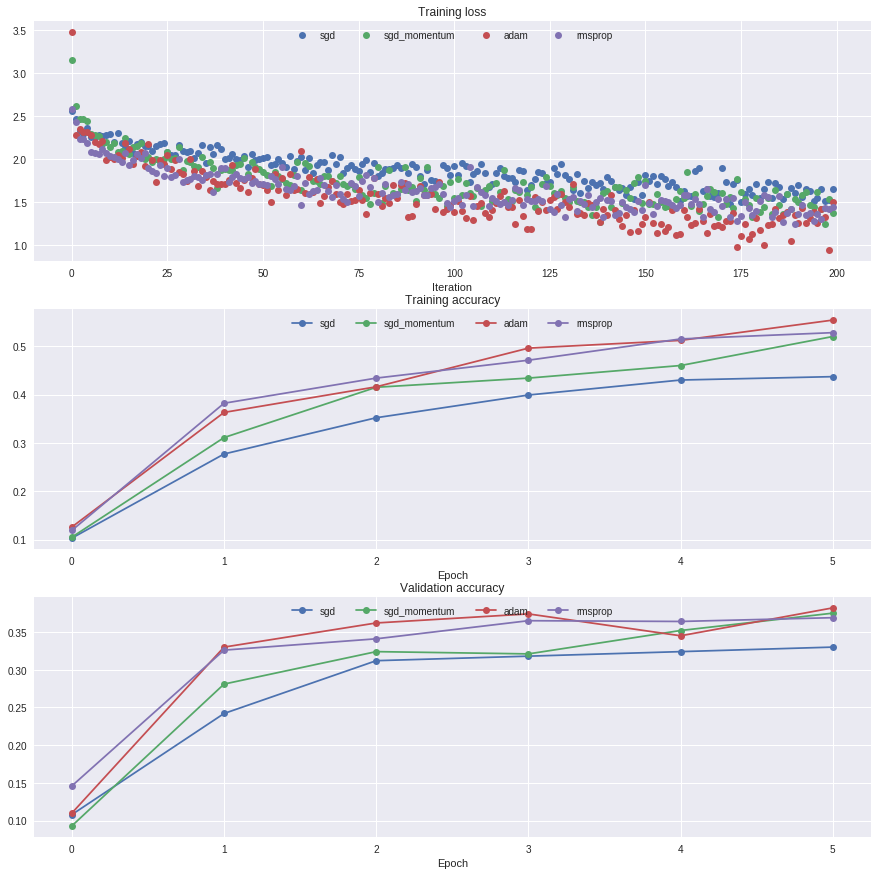

In [33]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
The updates become very small because the cache is always increasing in magnitude (we accumulate `dw**2` forever).
At some point `dw/sqrt(cache)` is very small.

Adam solves this by scaling the updates. "bias correction"


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

(Iteration 1 / 4900) loss: 11.794979
(Epoch 0 / 10) train acc: 0.118000; val_acc: 0.128000
(Iteration 101 / 4900) loss: 2.037306
(Iteration 201 / 4900) loss: 1.912892
(Iteration 301 / 4900) loss: 1.566941
(Iteration 401 / 4900) loss: 1.663887
(Epoch 1 / 10) train acc: 0.420000; val_acc: 0.395000
(Iteration 501 / 4900) loss: 1.569429
(Iteration 601 / 4900) loss: 1.596740
(Iteration 701 / 4900) loss: 1.418550
(Iteration 801 / 4900) loss: 1.356346
(Iteration 901 / 4900) loss: 1.438368
(Epoch 2 / 10) train acc: 0.509000; val_acc: 0.472000
(Iteration 1001 / 4900) loss: 1.513624
(Iteration 1101 / 4900) loss: 1.474855
(Iteration 1201 / 4900) loss: 1.598008
(Iteration 1301 / 4900) loss: 1.514923
(Iteration 1401 / 4900) loss: 1.373369
(Epoch 3 / 10) train acc: 0.475000; val_acc: 0.452000
(Iteration 1501 / 4900) loss: 1.313080
(Iteration 1601 / 4900) loss: 1.316517
(Iteration 1701 / 4900) loss: 1.373531
(Iteration 1801 / 4900) loss: 1.323345
(Iteration 1901 / 4900) loss: 1.351472
(Epoch 4 / 10) 

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


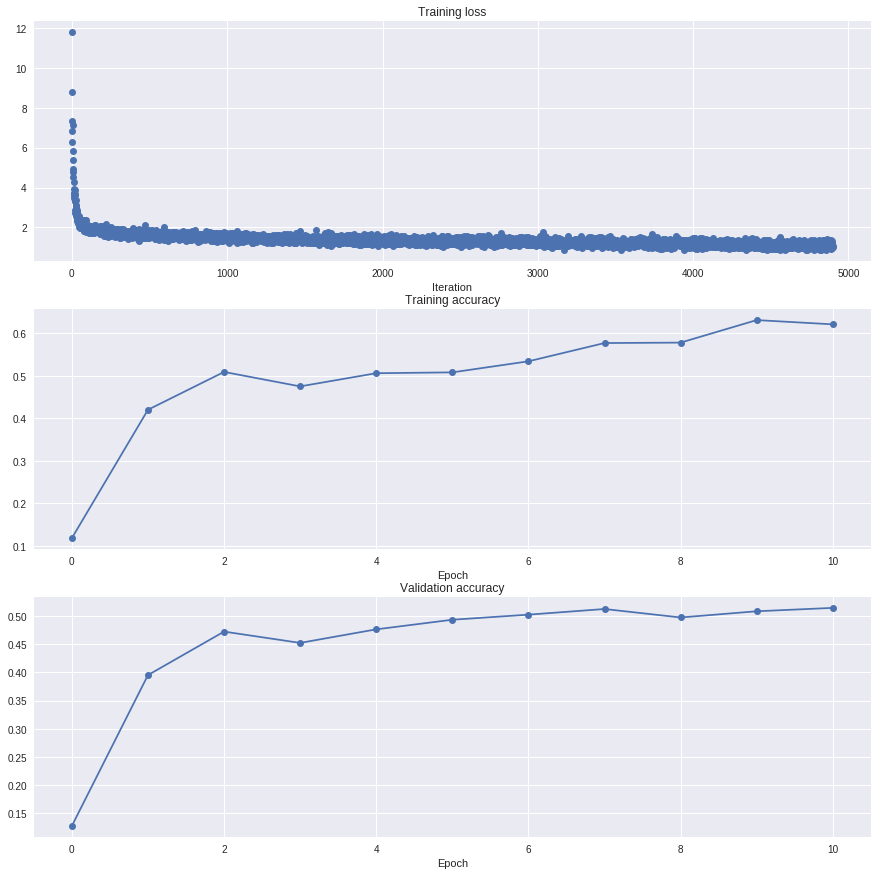

In [34]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
model = FullyConnectedNet([100, 100, 100], weight_scale=5e-2)
 
solver = Solver(model, data,
             update_rule='adam',
             optim_config={
                 'learning_rate': 1e-3,
             },
             lr_decay = 0.95,
             num_epochs=10, batch_size = 100,
             print_every=100)
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

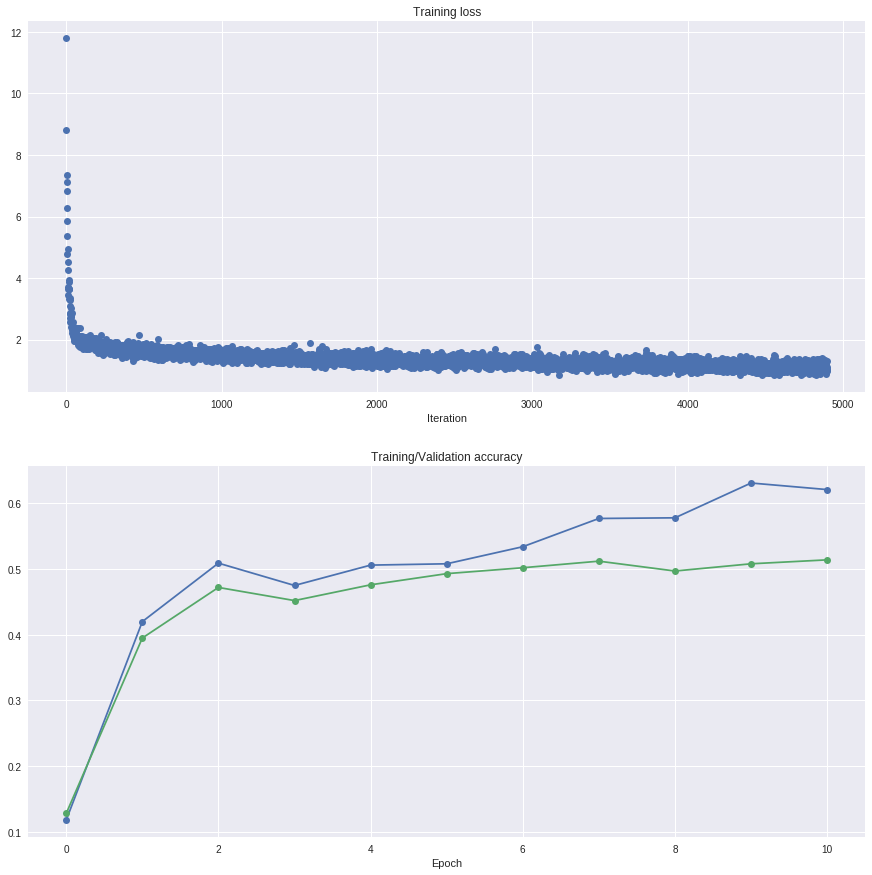

In [37]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(solver.loss_history, 'o')

plt.subplot(2,1, 2)
plt.title('Training/Validation accuracy')
plt.xlabel('Epoch')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')

plt.gcf().set_size_inches(15, 15)
plt.show()


In [0]:
best_model = model

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [40]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.514
Test set accuracy:  0.504
